### Set your Username and Password Here

In [219]:
u_name = "Sample_Username"
p_word = "Sample_password"

### Installing import_ipynb to import the previous notebook modules

In [3]:
!pip3 install import_ipynb

Defaulting to user installation because normal site-packages is not writeable


### Importing all the required modules

In [215]:
import selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.common.by import By
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import time
from datetime import date, timedelta
import import_ipynb
import InstaBot1 as ib
import math

### Functions used in the code, other than the previous ones.

In [4]:
def open_profile_user(driver, profile_name):
    url = f"https://www.instagram.com/{profile_name}/"
    driver.get(url)

In [5]:
def tot_followers(driver, profile_name):
    ### Open profile by user name, if user name is known, else, search and open the top profile
    try:
        open_profile_user(driver, profile_name)
    except:
        ib.open_profile(driver, profile_name)
    
    time.sleep(2)
    
    a_element = WebDriverWait(driver, 20).until(EC.visibility_of(driver.find_element(By.CSS_SELECTOR, 'a.x1i10hfl.xjbqb8w.x1ejq31n.xd10rxx.x1sy0etr.x17r0tee.x972fbf.xcfux6l.x1qhh985.xm0m39n.x9f619.x1ypdohk.xt0psk2.xe8uvvx.xdj266r.x11i5rnm.xat24cr.x1mh8g0r.xexx8yu.x4uap5.x18d9i69.xkhd6sd.x16tdsg8.x1hl2dhg.xggy1nq.x1a2a7pz._alvs._a6hd')))
    span_element = a_element.find_element('tag name', 'span')
    follower_count = int(span_element.get_attribute('title').replace(',', ''))
    return follower_count

In [192]:
### Function to compare to functions
def months(month1, month2):
    if month1 == 'Jan':
        return 0
    if month1 == 'Feb' and month2 == 'Jan':
        return 1
    if month1 == 'Mar' and month2 == 'Feb':
        return 1
    if month1 == 'Apr' and month2 == 'Mar':
        return 1
    if month1 == 'May' and month2 == 'Apr':
        return 1
    if month1 == 'Jun' and month2 == 'May':
        return 1
    if month1 == 'Jul' and month2 == 'Jun':
        return 1
    if month1 == 'Aug' and month2 == 'Jul':
        return 1
    if month1 == 'Sep' and month2 == 'Aug':
        return 1
    if month1 == 'Oct' and month2 == 'Sep':
        return 1
    if month1 == 'Nov' and month2 == 'Oct':
        return 1
    if month1 == 'Dec' and month2 == 'Nov':
        return 1
    return 0

In [191]:
# More efficient method, this will work, even if instagram updates it's UI
def check_date_range(driver, post_url, days):

    ### Fetching the post
    driver.get(post_url)
    time.sleep(1.5)

    ### Extracting post date
    post_date = driver.find_element(By.CSS_SELECTOR, 'time.x1p4m5qa').get_attribute('title')
    post_date = post_date.replace(',', '').split()
    p_day = int(post_date[1])
    p_month = post_date[0]
    p_year = int(post_date[2])

    ### Fetching today's date
    today = date.today()

    ### Fetching the date, 'days' days earlier
    dt = today - timedelta(days)
    d2 = dt.strftime("%b-%d-%Y").split('-')
    g_day = int(d2[1])
    g_month = d2[0]
    g_year = int(d2[2])

    ### Return True, if post year comes after given year
    if p_year > g_year:
        return 1

    ### Return True, if post month comes after given month
    if months(p_month, g_month):
        return 1

    ### Return True, if post day comes after or on given day
    if p_day >= g_day:
        return 1
    return 0

In [190]:
def recent_posts(driver, profile_name, scrolls = 4):
    ### Opening the given profile
    driver.get(f'https://www.instagram.com/{profile_name}/')

    time.sleep(2)

    links = []
    count = 0
    current_height = driver.execute_script('return document.body.scrollHeight')
    while True:
        ### Finding all the divs with the posts
        tot_divs = driver.find_elements(By.CSS_SELECTOR, 'div._ac7v.xras4av.xgc1b0m.xat24cr.xzboxd6')
        if len(tot_divs) < (scrolls):
            ### Scrolling to end of current height
            driver.execute_script(f'window.scrollTo(0, {current_height})')
            time.sleep(1)
            new_height = driver.execute_script('return document.body.scrollHeight')
            
            ### Break loop, if no scroll happens
            if new_height != current_height:
                current_height = new_height
                continue
        else:
            break

    ### Extracting all the post links
    for div_element in tot_divs:
        divs = div_element.find_elements(By.CSS_SELECTOR, 'div.x1lliihq.x1n2onr6.xh8yej3.x4gyw5p.xfllauq.xo2y696.x11i5rnm.x2pgyrj')
        for each_div in divs:
            link = each_div.find_element('tag name', 'a')
            url = link.get_attribute('href')
            links.append(url)
            count += 1
            if count == 30:
                break
        if count == 30:
            break

    return links

In [189]:
def posts_by_days(driver, profile_name, days = 3):
    ### Extracting the post urls
    post_urls = recent_posts(driver, profile_name)
    
    ### Creating a count and pin flag
    count = 0
    pin_flag = 0

    ### Iterating over all the post_urls
    for post_url in post_urls:
        
        ### Checking if the post lies within given date range
        if check_date_range(driver, post_url, days):
            count += 1
            
            ### Set pin flag, if one such post is found
            pin_flag += 1
        
        ### If post not in given day range and pin flag is set, break the loop
        elif pin_flag:
            break
    return count

In [122]:
def scrape_post(driver, post_url):
    driver.get(post_url)
    time.sleep(2)
    div_element = driver.find_elements(By.CSS_SELECTOR, 'div.x9f619.xjbqb8w.x78zum5.x168nmei.x13lgxp2.x5pf9jr.xo71vjh.x1uhb9sk.x1plvlek.xryxfnj.x1c4vz4f.x2lah0s.xdt5ytf.xqjyukv.x1qjc9v5.x1oa3qoh.x1nhvcw1')
    try:
        span_element = div_element[1].find_element(By.CSS_SELECTOR, 'span.x193iq5w.xeuugli.x1fj9vlw.x13faqbe.x1vvkbs.xt0psk2.x1i0vuye.xvs91rp.xo1l8bm.x5n08af.x10wh9bi.x1wdrske.x8viiok.x18hxmgj')
    except:
        span_element = div_element[2].find_element(By.CSS_SELECTOR, 'span.x193iq5w.xeuugli.x1fj9vlw.x13faqbe.x1vvkbs.xt0psk2.x1i0vuye.xvs91rp.xo1l8bm.x5n08af.x10wh9bi.x1wdrske.x8viiok.x18hxmgj')
    format_text = span_element.text
    format_text = format_text.replace('\n', ' ')
    format_text = format_text.replace('  ', ' ')
    return format_text

In [124]:
def post_content(driver, profile_name, count = 10):
    post_urls = recent_posts(driver, profile_name)[:count]
    posts_content = []
    for post_url in post_urls:
        posts_content.append(scrape_post(driver, post_url))

    return posts_content

In [187]:
def like_list(driver, profile_name, posts = 10):
    post_urls = recent_posts(driver, profile_name)[:posts]
    time.sleep(2)
    likes_list = []
    for post_url in post_urls:
        driver.get(post_url)
        time.sleep(2)
        try:
            like_div = driver.find_element(By.CSS_SELECTOR, 'div.x9f619.xjbqb8w.x78zum5.x168nmei.x13lgxp2.x5pf9jr.xo71vjh.x1n2onr6.x1plvlek.xryxfnj.x1iyjqo2.x2lwn1j.xeuugli.x1q0g3np.xqjyukv.x6s0dn4.x1oa3qoh.x1nhvcw1')
            like_span = like_div.find_element('tag name', 'span').find_element('tag name', 'span').find_element('tag name', 'span')
            likes = int(like_span.text.replace(',', ''))
        except:
            return 'likes are hidden for this profile'
        likes_list.append(likes)
    
    return likes_list

## MAIN Function Starts Here

#### Log in to Instagram

In [165]:
driver = webdriver.Chrome()
driver.get("https://www.instagram.com/")
ib.log_in_function(driver, u_name, p_word)

#### Question - 1

In [7]:
# 1.1

## Search 'food' and extract top 10 handles
ib.search_bar(driver, 'food')
time.sleep(2)
extracted_handles_list = ib.extract_handles(driver)[:10]

user_followers = []
for user_handle in extracted_handles_list:
    row = []
    row.append(user_handle)
    row.append(tot_followers(driver, user_handle))
    user_followers.append(row)

## Now, sort the list according to the number of followers in descending order
user_followers.sort(reverse = True, key = lambda x:x[1])

## Keeping the top 5 handles only
user_followers = user_followers[:5]

for user_handle in user_followers:
    print(user_handle)

['foodpharmer', 2611689]
['foodie_in_car', 434585]
['foodtalkindia', 308764]
['food', 182888]
['foodies_of_bhubaneswar', 117380]


In [66]:
# 1.2

posts_3 = {}
for user_handle in user_followers:
    posts_3[user_handle[0]] = posts_by_days(driver, user_handle[0])
print(posts_3)

{'foodpharmer': 3, 'foodie_in_car': 1, 'foodtalkindia': 5, 'food': 5, 'foodies_of_bhubaneswar': 1}


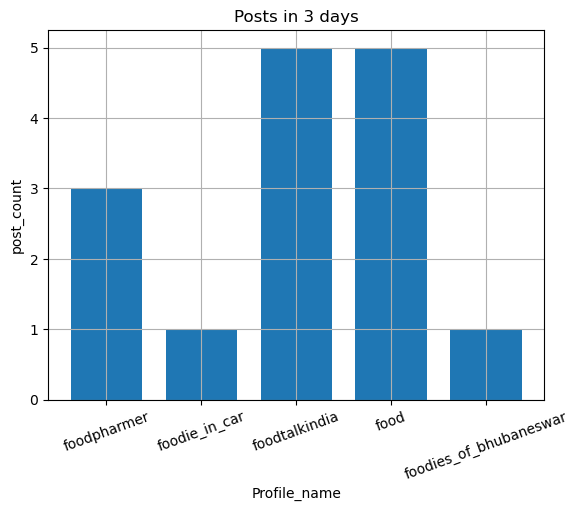

In [81]:
# 1.3

## Using Bar Graph to represent the data
handles = list(posts_3.keys())
post_count = list(posts_3.values())

plt.bar(handles, post_count, width = 0.75)

## Rotating lables, to avoid overlapping labels
plt.xticks(rotation = 20)

## Showing grids for easier inference
plt.grid()

## Assigning a label to the graph
plt.title('Posts in 3 days')

## Assigning y-label
plt.ylabel('post_count')

## Assigning x-label
plt.xlabel('Profile_name')
plt.show()

### Question - 2

In [126]:
# 2.1

contents = []
for handle in handles:
    content = post_content(driver, handle)
    print(handle,'\n',content)
    contents.append(content)

foodpharmer 
 ['Full version with more celebrities on YouTube! Link in bio. Challenge details: · Upload a story or a post with a label. · Challenge 3 more people to do the same. · Tag food pharmer if you want me to repost (optional). · Use the Label Padhega India music which is available on Instagram music library Get your kids, friends, office colleagues to participate in this challenge! I will also give some gifts to 100+ people and personally meet some people who do these challenge! Label Padhega India is a health movement to fight against all the food scandals happening in India! Every week we hear of a new food issue such as the Baby formula, Children’s health drink, Indian chips having Palm oil and the Masala-cancer issue. If majority of us started reading labels, companies will be forced to stop false marketing and start giving us better quality food! Let us all unite and transform India from the Diabetes Capital of the world to the Health Capital of the World! Note- Full credit

In [154]:
# 2.2 and 2.3

## Creating a single string from all the post contents
total_content = ''
for row in contents:
    for content in row:
        total_content = total_content + content

## Splitting the string at ' '
total_content = total_content.split()

word_wise = {}
for word in total_content:
    ## Formatting the word, before adding to the dictionary
    this_word = word.strip().lower()
    word_wise[this_word] = word_wise.get(this_word, 0) + 1

## Creating a nested list from the dictionary, to easily convert to pandas dataframe
word_list = []
for word in word_wise:
    word_list.append([word, word_wise[word]])

## Creating a pandas dataframe
df_words = pd.DataFrame(word_list, columns = ['Word', 'Frequency'])

## Sorting the DataFrame
df_words.sort_values('Frequency', axis=0, ascending=False, inplace=True, kind='quicksort', na_position='last', ignore_index=False, key=None)

## Reseting the index
df_words.reset_index(drop = True, inplace = True)
print(df_words)

## Exporting the CSV File
df_words.to_csv('word_freq.csv', index = False)

                      Word  Frequency
0                      the        146
1                        a         94
2                       to         93
3                       of         67
4                      and         66
...                    ...        ...
1813                 whole          1
1814         bar-takeovers          1
1815              electric          1
1816   9559081818exquisite          1
1817  #gastronomicdelights          1

[1818 rows x 2 columns]


In [155]:
# 2.4
## To Be Noted: DataFrame is already in Descending Order
## Boolean Indexing DataFrame to extract hashtags
hashes = df_words.Word.apply(lambda s: True if s[0] == '#' else False)
hash_df = df_words[hashes]

## Reseting the index
hash_df.reset_index(drop = True, inplace = True)

## Printing the resulting DataFrame
print(hash_df)

                      Word  Frequency
0              #asmreating         10
1               #asmrvideo         10
2              #asmrsounds         10
3           #asmrcommunity         10
4                    #asmr         10
..                     ...        ...
168                  #bars          1
169  #foodtalkindiathere’s          1
170                  #food          1
171    #aglassofworldclass          1
172   #gastronomicdelights          1

[173 rows x 2 columns]


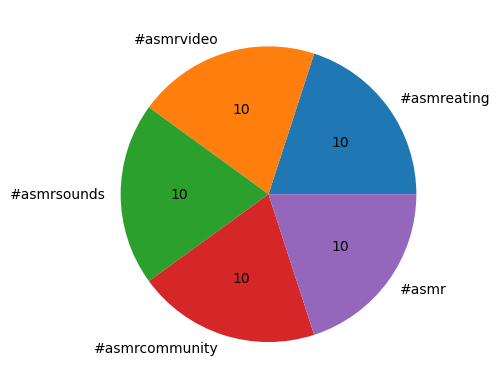

In [160]:
# 2.5

## Function to return the numbers to the pie chart
def pie_value(pct, freq):
    total = sum(freq)
    val = int(round(pct*total/100.0))
    return '{v:d}'.format(v=val)

word = []
freq = []
for index in hash_df.head().index:
    word.append(hash_df.iloc[index, 0])
    freq.append(hash_df.iloc[index, 1])

plt.pie(freq, labels = word, autopct = lambda pct: pie_value(pct, freq))
plt.show()

### Question - 3

In [188]:
# 3.1

## Extracting a list of likes on first 10 posts of the handle
handle_like_dict = {}
for handle in handles:
    handle_likes = like_list(driver, handle)
    handle_like_dict[handle] = handle_likes

print(handle_like_dict)

{'foodpharmer': [639158, 180952, 894531, 287329, 452773, 88938, 278131, 281609, 260928, 143551], 'foodie_in_car': [20747, 13168, 26337, 28684, 56826, 29297, 21771, 16254, 44484, 22431], 'foodtalkindia': [56, 623, 153, 32, 56, 55, 37, 142, 236, 7964], 'food': 'likes are hidden for this profile', 'foodies_of_bhubaneswar': 'likes are hidden for this profile'}


In [199]:
# 3.2
avg_dict = {}
for handle in handle_like_dict:
    likes = handle_like_dict[handle]
    
    ## Printing Error message if, likes are hidden
    if isinstance(likes, str):
        print(f'Cannot find Average because, like count is hidden for the profile: {handle}')
        continue

    ## Calculating avergae likes and storing in the dictionary otherwise
    like_sum = sum(likes)
    avg_dict[handle] = like_sum // 10

## Printing the dictionary containing the average likes of the handles
print('\n\nAverage Likes count (int)')
print(avg_dict)

Cannot find Average because, like count is hidden for the profile: food
Cannot find Average because, like count is hidden for the profile: foodies_of_bhubaneswar


Average Likes count (int)
{'foodpharmer': 350790, 'foodie_in_car': 27999, 'foodtalkindia': 935}


In [203]:
# 3.3

ratio_list = []
upd_handles = list(avg_dict.keys())

## Creating a dictionary of followers list
u_foll = {}
for f_count in user_followers:
    u_foll[f_count[0]] = f_count[1]
    
## Finding the like:follower ratio
for handle in avg_dict:
    fol_like_ratio = avg_dict[handle] / u_foll[handle]
    ratio_list.append(fol_like_ratio)

## Printing the ratio
for count in range(len(ratio_list)):
    print(f'Ratio for {upd_handles[count]} = {ratio_list[count]}')

Ratio for foodpharmer = 0.1343153798174285
Ratio for foodie_in_car = 0.06442698206334779
Ratio for foodtalkindia = 0.0030282027697529504


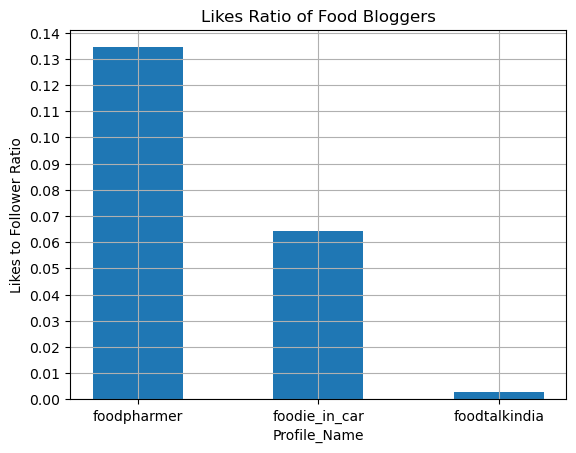

In [218]:
# 3.4

## Creating a bar graph to visualize the findings
plt.bar(upd_handles, ratio_list, width = 0.5)

## Naming the title of the graph
plt.title('Likes Ratio of Food Bloggers')

## Giving label on y-axis
plt.ylabel('Likes to Follower Ratio')

## Giving label on x-axis
plt.xlabel('Profile_Name')

## Assigning y-ticks
y_height = max(ratio_list) + 0.01
plt.yticks(np.arange(0, y_height, 0.01))

## Plotting grids for easier viewing of the graphs
plt.grid()

## Showing the graph
plt.show()